In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
%matplotlib notebook

# Construction Zone: Building a Metropolis-Hastings Sampler From Scratch

#### Version 0.1

-----

By AA Miller (Northwestern/Adler Planetarium)

27 Aug 2019

As we just saw, Bayes' Law provides a framework for understanding/inferring model parameters *given* some observations/data:

$$P(\theta\mid\mathbf{x}) = \frac{P(\mathbf{x}\mid\theta)\;P(\theta)}{P(\mathbf{x})},$$

where we have used the short-hand notation with $\theta$ representing the model parameters, and $\mathbf{x}$ representing the data. 

To redefine some terms,

$P(\mathbf{x}\mid\theta)$, the probability of the data given the model parameters, is the *likelihood*, $\mathcal{L}$.

$P(\theta)$, the probability of the model parameters, is the *prior*.

$P(\mathbf{x})$ the probability of the data, is the *evidence*. (That sounds weird right? More on this in a bit...)

Finally, $P(\theta\mid\mathbf{x})$, the probability of the model parameters given the data, is the *posterior*. 

We typically want to estimate some model parameters, $\theta$, and thus we need to integrate the posterior, $P(\theta\mid\mathbf{x})$.

This is **hard**.

In particular, how in the world are we supposed to estimate the *probability of data*?!

This is –– capital H –– **Hard**.

(We will discuss this on Friday)

Fortunately, $P(\mathbf{x})$ simply serves as a normalization term, and, in many applications, can be ignored. 

Thus, given that the posterior is $\propto \mathcal{L}\;P(\theta)$, we can maximize the posterior by maximizing the product of the likelihood and the prior. While this still leaves a complicated integral, there are many tools that can approximate that integral rather efficiently...

including the Metropolis-Hastings algorithm!

## Problem 1) Simulate the Observations

As we work towards implementing the MH sampler, we will attempt to solve a very common problem in the statistical literature: estimating the slope and intercept of a line from noisy data.

Here we will simulate some data with known model parameters so we can later compare our estimates to the correct answer.

**Problem 1a**

Draw 40 observations between 0 and 100 from a linear model with slope, $m = 2.3$, and intercept, $b = 15$. Assume that each observation is drawn from a Gaussian distribution with mean $\mu = 0$ and variance, $\sigma^2$ = 2500.

In [17]:
np.random.seed(212)
m_true = 2.3
b_true = 15
x = np.random.uniform(low=0, high=100, size=40)
y_true = b_true + m_true*x
y_obs = y_true + np.random.normal(0,50,size=40)
y_unc = np.ones_like(y_obs)*50

**Problem 1b**

Plot the observations and the corresponding uncertainties. Overplot a line showing the model from which the data were drawn.

<IPython.core.display.Javascript object>


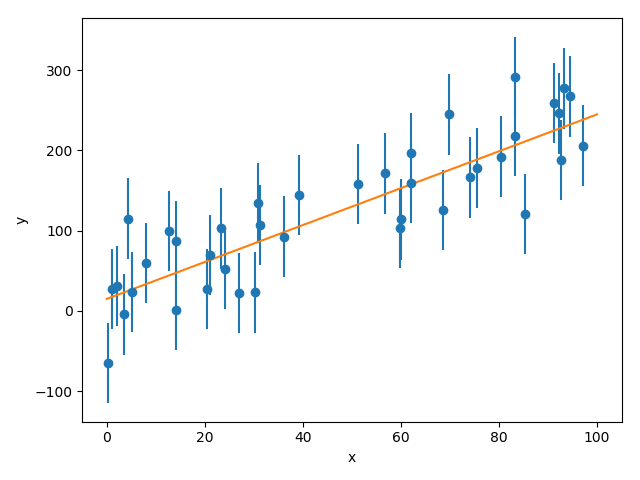

In [19]:
fig, ax = plt.subplots()

ax.errorbar(x, y_obs, y_unc, fmt='o')
ax.plot([0,100], b_true + m_true*np.array([0,100]))
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.tight_layout()

**Problem 1c**

Create a function `get_model_predictions` that calculates the expected value of $\mathbf{y}$ given input parameters `theta` and positions $\mathbf{x}$.

*Hint* - store the model parameters in a tuple `theta` = (m, b). This will make life easier later.

In [21]:
def get_model_predictions(theta, x):
    '''
    Calculate the model at any position x
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    Returns
    -------
    model_preds : arr-like, shape (n_samples)
        Array of model values
    '''
    m, b = theta
    model_preds = m*x + b
    
    return model_preds

## Problem 2) The Posterior

In order to approximate the posterior we need to be able to calculate it at any point within the multidimensional parameter space. 

Assuming gaussian distributed scatter in the observations, we can describe the probability of any individual observation as a function of the model parameters:

$$p(y_i \mid m, b, x_i, \sigma_i) = \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}},$$

where $y_i$ is the $i^\mathrm{th}$ observation, $x_i$ is the corresponding indpendent position at which $y_i$ is measured, $\sigma_{y_i}$ is the uncertainty on $y_i$ (constant in this case, but that doesn't have to be the case), and $m$ and $b$ are the slope and intercept for  the line.

Assuming the observations are independent, then the probability of *all* the observations is the product of the individual probabilities (note –– this is the likelihood):

$$\mathcal{L} = \prod_i p(y_i \mid m, b, x_i, \sigma_i) = \prod_i \frac{1}{\sqrt{2\pi\sigma_{y_i}^2}}\exp{- \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2}}.$$

This product produces really small numbers (individual observations have typical probabilities  < 0.3), which can become numerically unstable, especially for a poor choice of model parameters. 

A trick to alleviate this issue is to work with the $\log \mathcal{L}$, which using a logarithmic identity allows us to trade a product for a sum (computationally much easier!):

$$\log \mathcal{L} = \mathcal{K} - \sum_i \frac{(y_i - m\,x_i - b)^2}{2\sigma_{y_i}^2},$$

where $\mathcal{K}$ is a constant equal to $-\frac{n}{2}\log{2\pi} - \sum_i \log{\sigma_{y_i}}$.

Mathematically, maximizing the likelihood and the log likelihood are identical, and we will leverage this for the remainder of the problem.

**Problem 2a**

Write a function `lnlikelihood` to calculate the log likelihood given input parameters `theta`, `y`, `x`, and `y_unc`.

*Hint 1* –– the constant $\mathcal{K}$ is the same for any point in the parameter space. Thus it can be ignored as we only care about *relative* differences in the likelihood.

*Hint 2* –– store the model parameters in a single tuple `theta` = (m, b). This will make life easier later.

In [22]:
def lnlikelihood(theta, y, x, y_unc):
    '''
    Calculate the log likelihood for a model assuming Gaussian uncertainties
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnl : float
        The log-likelihood of the observations given the model parameters
    '''
    model_preds = get_model_predictions(theta, x)
    
    lnl = -np.sum((y-model_preds)**2/(2*y_unc**2))
    
    return lnl

**Problem 2b**

Confirm your function works by estimating the log likelihood for $m = 1.5$ and $b = 50$.

Is the log likelihood higher or lower if you use the true model parameters (see **1a**)? 

Does this make sense?

In [29]:
print('ln L for m=1.5 and b=50 is: {:.4f}'.format(lnlikelihood((1.5,50), y_obs, x, y_unc)))
print('ln L for m=2.3 and b=15 is: {:.4f}'.format(lnlikelihood((2.3,15), y_obs, x, y_unc)))

ln L for m=1.5 and b=10 is: -20.7939
ln L for m=2.3 and b=15 is: -14.9359


*write your answer here*

While a slope of 1.5 and intercept of 50 appears to agree with the majority of the observations, it is clear that the true model values provide a higher value of the likelihood.

The posterior requires an estimate of not just the likelihood, but also the prior. 

For this problem, how in the world do we choose the prior? 

(In practice, this can be very complicated and we will discuss this in more detail on Wednesday and Friday)

When you have little to no knowledge of the actual model parameters, it is often "safe" to assume a wide and flat prior (sometimes referred to as an uniformative prior). A wide and flat prior essentially says that any value within the bounds of the prior is equally likely, while values outside the bounds are unacceptable. 

While we know the true answer, let's pretend that we don't. From the data (technically, using the data to estimate the prior is cheating, as we'll discuss on Friday) we can see that the slope is definitely positive, and also definitely less than 300 (the largest y value in the data set). Thus, we will set a uniform prior on $m$ from 0 to 300:

$$P(m) \sim \mathcal{U}(0,300).$$

From similar arguments the intercept is likely somewhere between -100 and 100:

$$P(b) \sim \mathcal{U}(-100,100).$$


**Problem 2c**

Write a function `lnprior` to calculate the log of the prior from an input tuple of the model parameters `theta`.

*Hint* - while the $\log{0}$ is undefined, have the function return `-np.inf` for values outside the bounds of the prior.

In [30]:
def lnprior(theta):
    '''
    Calculate the log of the prior for the model parameters
    
    Parameters
    ----------
    theta : tuple
        Model parameters
            
    Returns
    -------
    lnp : float
        The log-prior of the model parameters
    '''
    m, b = theta
    if 0 <= m <= 300 and -100 <= b <= 100:
        lnp = np.log(1/300) + np.log(1/200) # assumes P(m) and P(y) are completely independent
    else:
        return -np.inf
    
    return lnp

**Problem 2d**

Calculate the prior for $(m, b) = (1, 0)$, $(2.3, 15)$, $(3, -150)$, and $(-1, 90)$.

Do your answers make sense?

In [32]:
print('ln P for m=1.0 and b=0 is: {:.4f}'.format(lnprior((1.5,50))))
print('ln P for m=2.3 and b=15 is: {:.4f}'.format(lnprior((2.3,15))))
print('ln P for m=3 and b=-150 is: {:.4f}'.format(lnprior((3,-150))))
print('ln P for m=-1 and b=90 is: {:.4f}'.format(lnprior((-1,90))))

ln P for m=1.0 and b=0 is: -11.0021
ln P for m=2.3 and b=15 is: -11.0021
ln P for m=3 and b=-150 is: -inf
ln P for m=-1 and b=90 is: -inf


*write your answer here*

These answers to make sense. For model parameters within the bounds of the prior all values are equally likely, whereas there is no probability for model parameters outside the bounds of the model.

**Problem 2e**

Write a function `lnposterior` to calculate the log of the posterior.

*Hint* - this is straightforward using functions you have already written.

In [33]:
def lnposterior(theta, y, x, y_unc):
    '''
    Calculate the log posterior
    
    Parameters
    ----------
    theta : tuple
        Model parameters
    
    y : arr-like, shape (n_samples)
        Array of observational measurements
    
    x : arr-like, shape (n_samples)
        Array of positions where y is measured
    
    y_unc : arr-like, shape (n_samples)
        Array of uncertainties on y
        
    Returns
    -------
    lnpost : float
        The log-posterior from the observations and model parameters
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    lnl = lnlikelihood(theta, y, x, y_unc)
    lnpost = lnl + lnp
        
    return lnpost

**Problem 2f**

What is the log posterior for $m = 1.5$ and $b = 50$?

What is the log posterior for $m = 2.3$ and $b = 15$?

What is the log posterior for $m = 1.5$ and $b = 200$?

Does this make sense?

In [34]:
print('ln posterior for m=1.5 and b=50 is: {:.4f}'.format(lnposterior((1.5,50), y_obs, x, y_unc)))
print('ln posterior for m=2.3 and b=15 is: {:.4f}'.format(lnposterior((2.3,15), y_obs, x, y_unc)))
print('ln posterior for m=1.5 and b=200 is: {:.4f}'.format(lnposterior((1.5,200), y_obs, x, y_unc)))


ln posterior for m=1.5 and b=50 is: -31.7960
ln posterior for m=2.3 and b=15 is: -25.9380
ln posterior for m=1.5 and b=200 is: -inf


*write your answer here*

These answers make sense. There is no probability outside the prior, and the posterior values are lower than the likelihood values.

## Problem 3) The Metropolis-Hastings Algorithm

The [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) is the most simple [Markov Chain](https://en.wikipedia.org/wiki/Markov_chain) [Monte Carlo](https://en.wikipedia.org/wiki/Monte_Carlo_method) ([MCMC](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) procedure for estimating Bayesian posteriors. 

We will get 

In [ ]:
oh damn damn triple damn